In [1]:
import nltk
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Text Preprocessing

In [2]:
df = pd.read_csv('dataset/text/prabowo_clean_text.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10931 entries, 0 to 10930
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.2    10931 non-null  int64  
 1   Unnamed: 0.1    10931 non-null  int64  
 2   Unnamed: 0      10931 non-null  int64  
 3   full_text       10931 non-null  object 
 4   label           10931 non-null  object 
 5   score           10931 non-null  float64
 6   text_processed  10931 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 597.9+ KB


In [4]:
df_prabowo = pd.read_csv('dataset/text/prabowo_clean_text.csv')
df_prabowo['label_num'] = df_prabowo['label'].replace({'neutral' : 0, 'positive' : 1, 'negative' : 2})
df_prabowo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10931 entries, 0 to 10930
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.2    10931 non-null  int64  
 1   Unnamed: 0.1    10931 non-null  int64  
 2   Unnamed: 0      10931 non-null  int64  
 3   full_text       10931 non-null  object 
 4   label           10931 non-null  object 
 5   score           10931 non-null  float64
 6   text_processed  10931 non-null  object 
 7   label_num       10931 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 683.3+ KB


In [5]:
df1 = df_prabowo.copy()
df1 = df1[
    ((df1['label'] == 'negative') & (df1['score'] >= 0.6)) |
    ((df1['label'] == 'neutral') & (df1['score'] >= 0.97)) |
    ((df1['label'] == 'positive') & (df1['score'] >= 0.55))
]
df1['label'].value_counts()

label
neutral     2408
negative    1948
positive     970
Name: count, dtype: int64

In [6]:
import pandas as pd

# Misal df1 dan df2 sudah ada dan punya kolom yang sama
df = df1
df['label_num'] = df['label'].replace({'neutral' : 0, 'positive' : 1, 'negative' : 2})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5326 entries, 0 to 10929
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.2    5326 non-null   int64  
 1   Unnamed: 0.1    5326 non-null   int64  
 2   Unnamed: 0      5326 non-null   int64  
 3   full_text       5326 non-null   object 
 4   label           5326 non-null   object 
 5   score           5326 non-null   float64
 6   text_processed  5326 non-null   object 
 7   label_num       5326 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 374.5+ KB


In [87]:
df.drop(['score', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6326 entries, 0 to 6325
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   full_text       6326 non-null   object
 1   label           6326 non-null   object
 2   text_processed  6325 non-null   object
 3   label_num       6326 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 197.8+ KB


In [7]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5326 entries, 0 to 10929
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.2    5326 non-null   int64  
 1   Unnamed: 0.1    5326 non-null   int64  
 2   Unnamed: 0      5326 non-null   int64  
 3   full_text       5326 non-null   object 
 4   label           5326 non-null   object 
 5   score           5326 non-null   float64
 6   text_processed  5326 non-null   object 
 7   label_num       5326 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 374.5+ KB


In [81]:
df.to_csv('df.csv')

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# 1. Inisialisasi dan fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_processed'])

# 2. Tentukan MAX_WORDS berdasarkan jumlah kata unik
total_kata_unik = len(tokenizer.word_index)
print("Jumlah kata unik:", total_kata_unik)

# Atur MAX_WORDS agar tidak terlalu besar
if total_kata_unik > 20000:
    MAX_WORDS = 15000
elif total_kata_unik > 10000:
    MAX_WORDS = 10000
else:
    MAX_WORDS = total_kata_unik

print("MAX_WORDS yang digunakan:", MAX_WORDS)

Jumlah kata unik: 8682
MAX_WORDS yang digunakan: 8682


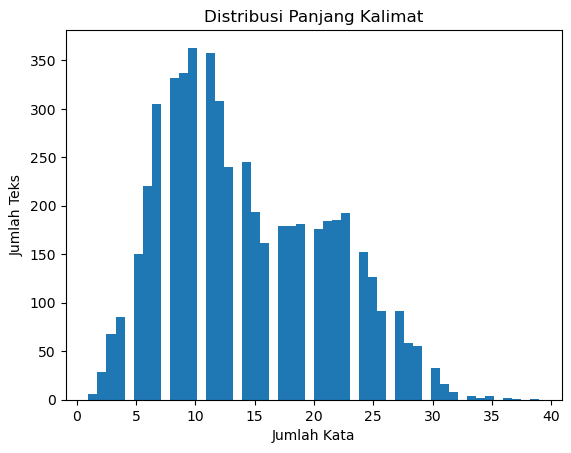

MAX_LEN (persentil 95): 27


In [9]:
# 3. Hitung panjang tiap kalimat
sequences = tokenizer.texts_to_sequences(df['text_processed'])
panjang_kalimat = [len(seq) for seq in sequences]

# 4. Tentukan MAX_LEN berdasarkan distribusi panjang
plt.hist(panjang_kalimat, bins=50)
plt.title('Distribusi Panjang Kalimat')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Teks')
plt.show()

MAX_LEN = int(np.percentile(panjang_kalimat, 95))
print("MAX_LEN (persentil 95):", MAX_LEN)

In [10]:
# 5. Lakukan ulang tokenizer dengan batasan MAX_WORDS
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_processed'])
sequences = tokenizer.texts_to_sequences(df['text_processed'])

# 6. Padding sequences
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Feature Engineering

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df['label_num'], test_size=0.3, random_state=42, stratify=df['label_num']
)
y_train.value_counts(), y_test.value_counts()

(label_num
 0    1685
 2    1364
 1     679
 Name: count, dtype: int64,
 label_num
 0    723
 2    584
 1    291
 Name: count, dtype: int64)

# Model Architecture Definition

# Training Model

In [12]:
import numpy as np
print(np.unique(y_train, return_counts=True))  # Cek distribusi kelas

(array([0, 1, 2], dtype=int64), array([1685,  679, 1364], dtype=int64))


In [13]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.7374876360039565, 1: 1.8301423662248404, 2: 0.9110459433040078}

In [14]:
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional  
from keras import regularizers  
from keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from keras.layers import BatchNormalization


model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN))

model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(GRU(32))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Output layer
model.add(Dense(3, activation='softmax'))

# Kompilasi model dengan learning rate yang lebih kecil
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping],
    # class_weight=class_weights  
)

Epoch 1/100
117/117 [==============================] - 12s 51ms/step - loss: 1.2571 - accuracy: 0.3914 - val_loss: 1.0414 - val_accuracy: 0.4568
Epoch 2/100
117/117 [==============================] - 5s 39ms/step - loss: 1.0413 - accuracy: 0.4903 - val_loss: 1.0366 - val_accuracy: 0.4793
Epoch 3/100
117/117 [==============================] - 5s 39ms/step - loss: 0.7679 - accuracy: 0.6714 - val_loss: 0.9931 - val_accuracy: 0.4825
Epoch 4/100
117/117 [==============================] - 4s 38ms/step - loss: 0.4664 - accuracy: 0.8238 - val_loss: 1.0384 - val_accuracy: 0.4962
Epoch 5/100
117/117 [==============================] - 4s 38ms/step - loss: 0.3113 - accuracy: 0.8973 - val_loss: 1.2439 - val_accuracy: 0.5601
Epoch 6/100
117/117 [==============================] - 4s 38ms/step - loss: 0.2394 - accuracy: 0.9276 - val_loss: 1.4331 - val_accuracy: 0.5538
Epoch 7/100
117/117 [==============================] - 4s 38ms/step - loss: 0.2043 - accuracy: 0.9332 - val_loss: 1.7531 - val_accuracy

model.add(BatchNormalization())


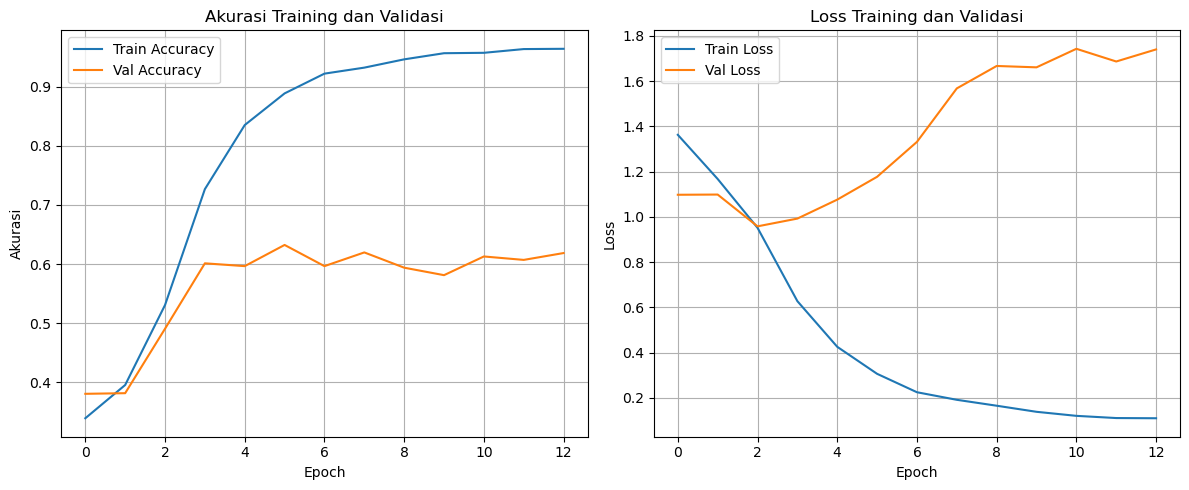

In [99]:
import matplotlib.pyplot as plt

# Ambil data dari history
history_dict = history.history

# --- Plot Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


60/60 [==============================] - 4s 19ms/step


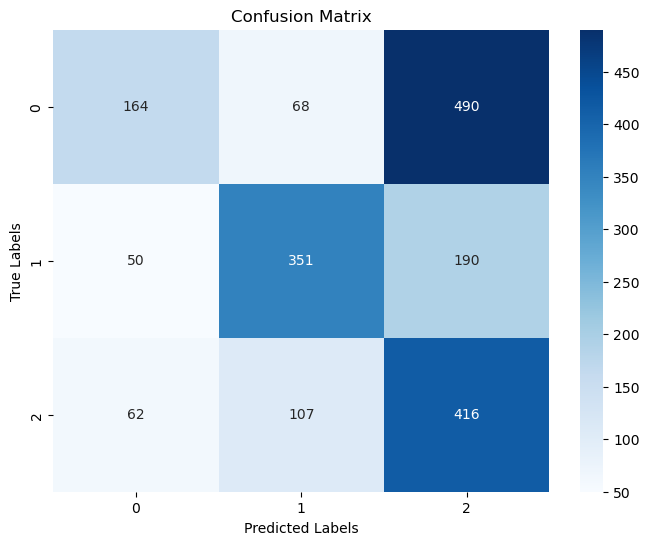

              precision    recall  f1-score   support

           0       0.59      0.23      0.33       722
           1       0.67      0.59      0.63       591
           2       0.38      0.71      0.49       585

    accuracy                           0.49      1898
   macro avg       0.55      0.51      0.48      1898
weighted avg       0.55      0.49      0.47      1898



In [98]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prediksi
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Mengambil indeks dengan probabilitas tertinggi

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['Netral', 'Positif', 'Negatif']

# 3. Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 4. Laporan klasifikasi (opsional tapi berguna)
print(classification_report(y_test, y_pred))


In [31]:
y_train[:5]

2251    0
226     1
3991    0
670     0
66      1
Name: label_num, dtype: int64